## The MNIST Dataset of Handwritten Digits.
This database contains 60,000 handwritten digits in the training set and around 10,000 handwritten digits in the test in 28x28 resolution. <br>
We will be using the dataset in CSV format, as prepared by [*pjreddie*](https://pjreddie.com). <br> 
We will be training a Convolutional Neural Network (CNN) to predict the class of digits (i.e. 0 - 9) using PyTorch library in Python.

## Table of Contents
1. [Importing modules and the dataset](#1)
2. [Some Exploratory Data Analysis](#2)
3. [Featurization](#3)
4. [Model training](#4)
5. [Evaluation](#5)
6. [Conclusion](#6)

In [1]:
# Set up
import numpy as np
import pandas as pd
import json
import pickle
import time

# Visualizations
import seaborn as sns 
import matplotlib.pyplot as plt

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data 
import torch.optim as optim 
from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv('../data/train_data.csv', header=None, dtype=float)
test_data = pd.read_csv('../data/test_data.csv', header=None, dtype=float)

In [3]:
print(f'Shape of training dataset is: {train_data.shape}')
print(f'Shape of testing dataset is: {test_data.shape}')

Shape of training dataset is: (60000, 785)
Shape of testing dataset is: (10000, 785)


In [4]:
display(train_data.head())

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The target feature (i.e. the digit label) is stored in the column named '0'.

<div id='2'></div>

<br>

### **2. Some Exploratory Data Analysis**

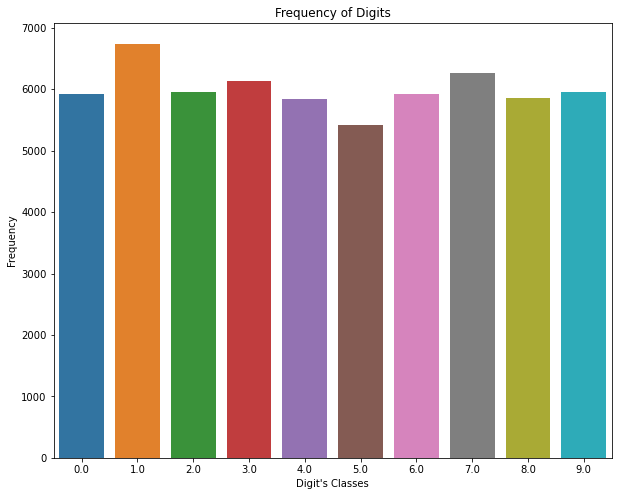

In [5]:
plt.figure(figsize=(10, 8))
sns.countplot(x = 0, data=train_data)

plt.xlabel("Digit's Classes")
plt.ylabel('Frequency')
plt.title('Frequency of Digits')
plt.show()

The data seems to be balanced. <br>

<div id='3'></div>

<br>

### **3. Featurization**
Colors take value from 0 - 255 (in RGB), but to apply CNN its much better to make them 0 - 1. That is, making them grayscale.

In [6]:
# We pick all the columns except the first one, as it is the target feature (label) column.
train_mean = train_data.values[:, 1:].mean()
train_std = train_data.values[:, 1:].std()

In [7]:
# Normalizing train and test data according to the train data distribution 
train_data.values[:, 1:] -= train_mean
train_data.values[:, 1:] /= train_std
test_data.values[:, 1:] -= train_mean
test_data.values[:, 1:] /= train_std

In [8]:
print(f'mean:{train_mean}, std:{train_std}')

mean:33.318421449829934, std:78.56748998339742


In [9]:
print("Saving processed datasets and normalization parameters...")
# Save normalized data-sets
np.save('../data/processed_train_data', train_data)
np.save('../data/processed_test_data', test_data)
print('done.')

Saving processed datasets and normalization parameters...
done.


<div id='4'></div>

<br>

### **4. Model Training**

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 100)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def printmodel(self):
        from torchvision import models
        model = models.vgg16()
        print(model)

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    log_interval = 100
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def train_model():
    # Measure training time
    start_time = time.time()

    # Setting up network
    print("Setting up Params...")
    device = torch.device("cpu")
    batch_size = 64
    epochs = 3
    learning_rate = 0.01
    momentum = 0.5
    print("done.")

    # Load training data
    print("Load training data...")
    train_data = np.load('../data/processed_train_data.npy')

    # Divide loaded data-set into data and labels
    labels = torch.Tensor(train_data[:, 0]).long()
    data = torch.Tensor(train_data[:, 1:].reshape([train_data.shape[0], 1, 28, 28]))
    torch_train_data = torch.utils.data.TensorDataset(data, labels)
    train_loader = torch.utils.data.DataLoader(torch_train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    print("done.")

    # Define SVM classifier and train model
    print("Training model...")
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate,
                          momentum=momentum)

    model.printmodel()
    
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
    print("done.")

    # Save model as pkl
    print("Save model and training time metric...")
    with open("../data/model.pkl", 'wb') as f:
        pickle.dump(model, f)

    # End training time measurement
    end_time = time.time()
    print(f'training_time: {end_time - start_time}')

In [13]:
train_model()

Setting up Params...
done.
Load training data...
done.
Training model...
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace

/home/swarajpande/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.764109
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.483026
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.345937
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.271265
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.319492
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.182181
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.120749
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.062898
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.207629
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.089428
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.206711
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.137870
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.068225
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.068546
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.073166
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.015309
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.028978
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.104812
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.059900
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.148229
Train Epoch:

<div id='5'></div>

<br>

### **5. Evaluation**

In [16]:
def eval_model():
    # Load test data
    print("Loading data and model...")
    test_data = np.load('../data/processed_test_data.npy')

    # Load trained model
    with open('../data/model.pkl', 'rb') as f:
        model = pickle.load(f)

    # Switch model to evaluation (inference) mode
    model.eval()

    print("done.")

    # Divide loaded data-set into data and labels
    labels = test_data[:, 0]
    data = torch.Tensor(test_data[:, 1:].reshape([test_data.shape[0], 1, 28, 28]))

    # Run model on test data
    print("Running model on test data...")
    predictions = model(data).max(1, keepdim=True)[1].cpu().data.numpy()
    print("done.")

    print(f"accuracy: {accuracy_score(labels, predictions)}")

In [17]:
eval_model()

Loading data and model...
done.
Running model on test data...
done.
accuracy: 0.9845


<div id='6'></div>

<br>

### **6. Conclusion**
We trained a Convolutional Neural Network, and achieved 98.45% accuracy on the test set.